<a href="https://colab.research.google.com/github/LatifulJoy/covid19-cnn-TL-mobilenet/blob/main/newcov19_3722.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os 
import pathlib 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import random
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D,SeparableConv2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from google.colab import files
from sklearn.metrics import classification_report,confusion_matrix

In [2]:
files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"latifuljoy","key":"5c49d122e1611b73411415358fb0fe9a"}'}

In [3]:
import os
os.environ["KAGGLE_CONFIG_DIR"] = "/content"

In [4]:
!kaggle datasets download -d sid321axn/covid-cxr-image-dataset-research

 99% 568M/572M [00:03<00:00, 165MB/s]
100% 572M/572M [00:03<00:00, 190MB/s]


In [5]:
!unzip \*.zip

Archive:  covid-cxr-image-dataset-research.zip
  inflating: COVID_IEEE/covid/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg  
  inflating: COVID_IEEE/covid/03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C.jpeg  
  inflating: COVID_IEEE/covid/1-s2.0-S0140673620303706-fx1_lrg.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-a.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-b.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-c.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-d.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300608-main.pdf-001.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300608-main.pdf-002.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-002-a1.png  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-002-a2.png  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-003-b1.png  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-003-b2.pn

In [6]:
for dirpath,dirnames,filenames in os.walk("/content/COVID_IEEE"):
    print(f"there are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

there are 3 directories and 0 images in '/content/COVID_IEEE'.
there are 0 directories and 619 images in '/content/COVID_IEEE/virus'.
there are 0 directories and 536 images in '/content/COVID_IEEE/covid'.
there are 0 directories and 668 images in '/content/COVID_IEEE/normal'.


In [7]:
data_dir = pathlib.Path("/content/COVID_IEEE")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
class_names

array(['covid', 'normal', 'virus'], dtype='<U6')

In [8]:
def view_image(target_dir, target_class):
    target_folder = target_dir+target_class
    random_image = random.sample(os.listdir(target_folder),1)
    print(random_image)
    img = mpimg.imread(target_folder+"/"+ random_image[0])
    plt.imshow(img, cmap ="gray")
    plt.title(target_class)
    plt.axis("off")
    print(f"image shape {img.shape}")
    
    return img

['person1233_virus_2090.jpeg']
image shape (656, 1224)


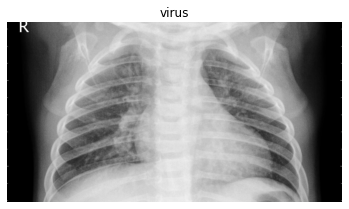

In [9]:
img = view_image("/content/COVID_IEEE/","virus")

['IM-0185-0001.jpeg']
image shape (1190, 1458)


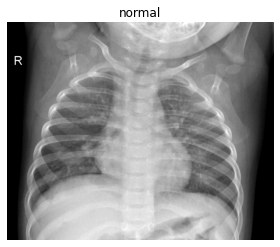

In [10]:
img = view_image("/content/COVID_IEEE/","normal")

['EUNO4YLXQAMnLsT.jfif']
image shape (2638, 2604, 3)


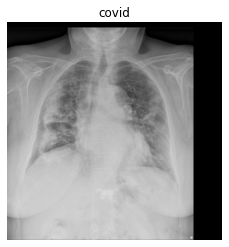

In [11]:
img = view_image("/content/COVID_IEEE/","covid")

In [12]:
data=[]
labels=[]
covid=os.listdir("/content/COVID_IEEE/covid/")
for a in covid:

    image = cv2.imread("/content/COVID_IEEE/covid/"+a,)
    image = cv2.resize(image, (224, 224))


    data.append(image)
    labels.append(0)

In [13]:
normal=os.listdir("/content/COVID_IEEE/normal/")
for a in normal:

    image = cv2.imread("/content/COVID_IEEE/normal/"+a,)
    image = cv2.resize(image, (224, 224))



    data.append(image)
    labels.append(1)

In [14]:
virus=os.listdir("/content/COVID_IEEE/virus/")
for a in virus:

    image = cv2.imread("/content/COVID_IEEE/virus/"+a,)
    image = cv2.resize(image, (224, 224))
    

    data.append(image)
    labels.append(2)

In [15]:
data = np.array(data) / 255.0
img_labels = np.array(labels)

In [16]:
data

array([[[[0.01568627, 0.        , 0.        ],
         [0.02352941, 0.00392157, 0.00784314],
         [0.01960784, 0.00392157, 0.00392157],
         ...,
         [0.01568627, 0.        , 0.        ],
         [0.01960784, 0.        , 0.00392157],
         [0.02745098, 0.00784314, 0.01176471]],

        [[0.02352941, 0.00392157, 0.00784314],
         [0.02745098, 0.00784314, 0.01176471],
         [0.02352941, 0.00784314, 0.00784314],
         ...,
         [0.01568627, 0.        , 0.        ],
         [0.01960784, 0.        , 0.00392157],
         [0.02745098, 0.00784314, 0.01176471]],

        [[0.12156863, 0.10196078, 0.10588235],
         [0.13333333, 0.11372549, 0.11764706],
         [0.12941176, 0.10980392, 0.11372549],
         ...,
         [0.01568627, 0.        , 0.        ],
         [0.01960784, 0.        , 0.00392157],
         [0.02745098, 0.00784314, 0.01176471]],

        ...,

        [[0.63529412, 0.62352941, 0.60784314],
         [0.70196078, 0.69411765, 0.6745098 ]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(data, img_labels, test_size=0.20, random_state=42)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)

In [18]:
print("The size of the test dataset is: ", X_test.shape)
print("The size of the remaining dataset is : ", X_train.shape)

The size of the test dataset is:  (365, 224, 224, 3)
The size of the remaining dataset is :  (1458, 224, 224, 3)


In [19]:
#Split again into train and test to create small training and testing dataset
X_train1, X_valid, y_train1, y_valid = train_test_split(X_train, y_train, test_size = 0.25, random_state = 42)
print("The size of training dataset is: ", X_train.shape)
print("The size of validation dataset is: ", X_valid.shape)
print("The size of training dataset y is: ", y_train.shape)
print("The size of validation dataset y is: ", y_valid.shape)

The size of training dataset is:  (1458, 224, 224, 3)
The size of validation dataset is:  (365, 224, 224, 3)
The size of training dataset y is:  (1458, 3)
The size of validation dataset y is:  (365, 3)


In [20]:
import tensorflow as tf
opt=tf.keras.optimizers.Adam(learning_rate=0.0001)

In [21]:
model = Sequential()

#Block Number 1
model.add(Conv2D(input_shape = (224,224,3), filters=32,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(Conv2D(filters=32,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(MaxPool2D((2,2)))

Dropout(0.25)

#Block Number 2
model.add(Conv2D(filters=64,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))


model.add(Conv2D(filters=64,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(MaxPool2D((2,2)))
model.add(MaxPool2D((2,2)))
Dropout(0.25)

#Block Number 3
model.add(Conv2D(filters=128,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(Conv2D(filters=128,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(MaxPool2D((2,2)))

model.add(MaxPool2D((2,2)))
Dropout(0.25)

#Block Number 4
model.add(Conv2D(filters=256,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(Conv2D(filters=256,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(MaxPool2D((2,2)))

model.add(MaxPool2D((2,2)))
Dropout(0.25)

# Fully Connected layer
model.add(Flatten())

model.add(Dense(units=1024, activation="relu"))
Dropout(0.25)

model.add(Dense(units=128, activation="relu"))
Dropout(0.25)

model.add(Dense(units=3, activation="softmax"))

model.compile(optimizer= opt ,loss='kullback_leibler_divergence',metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 activation (Activation)     (None, 224, 224, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                        

In [23]:
model.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=32)

Epoch 1/20
37/37 [==============================] - 320s 9s/step - loss: 1.0589 - accuracy: 0.3954 - val_loss: 0.9249 - val_accuracy: 0.4966
Epoch 2/20
37/37 [==============================] - 318s 9s/step - loss: 0.6815 - accuracy: 0.6990 - val_loss: 0.5047 - val_accuracy: 0.8527
Epoch 3/20
37/37 [==============================] - 319s 9s/step - loss: 0.4580 - accuracy: 0.8345 - val_loss: 0.4850 - val_accuracy: 0.8048
Epoch 4/20
37/37 [==============================] - 317s 9s/step - loss: 0.3507 - accuracy: 0.8748 - val_loss: 0.2777 - val_accuracy: 0.9041
Epoch 5/20
37/37 [==============================] - 318s 9s/step - loss: 0.2666 - accuracy: 0.9134 - val_loss: 0.2349 - val_accuracy: 0.9178
Epoch 6/20
37/37 [==============================] - 317s 9s/step - loss: 0.2643 - accuracy: 0.9048 - val_loss: 0.3938 - val_accuracy: 0.8322
Epoch 7/20
37/37 [==============================] - 318s 9s/step - loss: 0.2375 - accuracy: 0.9160 - val_loss: 0.3423 - val_accuracy: 0.8870
Epoch 8/20
37

Text(0.5, 1.0, 'Training-Validation Accuracy')

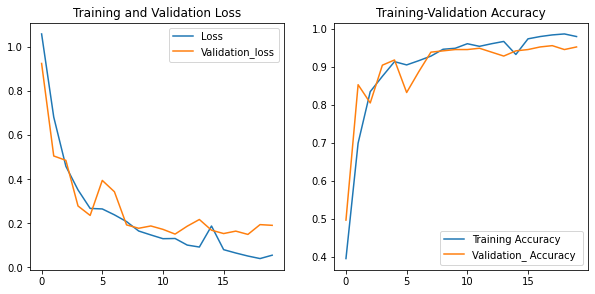

In [24]:
#saving the model history
loss = pd.DataFrame(model.history.history)

#plotting the loss and accuracy 
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.plot(loss["loss"], label ="Loss")
plt.plot(loss["val_loss"], label = "Validation_loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(2,2,2)
plt.plot(loss['accuracy'],label = "Training Accuracy")
plt.plot(loss['val_accuracy'], label ="Validation_ Accuracy ")
plt.legend()
plt.title("Training-Validation Accuracy")

In [25]:
predictions = model.predict(X_test)

y_pred = np.argmax(predictions, axis = 1)
y_test_new = np.argmax(y_test, axis = 1)

In [26]:
print(classification_report(y_test_new, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       108
           1       0.97      0.93      0.95       129
           2       0.95      0.95      0.95       128

    accuracy                           0.95       365
   macro avg       0.95      0.96      0.95       365
weighted avg       0.95      0.95      0.95       365

